<h1><center><font size="5", color='steelblue'><b> Dealing with imbalanced datasets using pipelines  </b></font></center></h1>

<h2><center><font size="4"> Credit card fraud dataset</font></center></h2>

## <a id='0'><h3 class="list-group-item list-group-item-action active" data-toggle="list" role="tab" aria-controls="home">Table of Contents</h3></a>

- <a href="#1">Introduction</a>
    - <a href="#11">Notions about imbalanced data</a>
- <a href="#2">Initial data exploration</a>
    - <a href="#21">Simple histogram to check distribution of features</a>
- <a href="#3">Designing pipelines and generating a baseline</a>
    - <a href="#31">Splitting data in training, validation and test sets</a>
    - <a href="#32">Check target feature imbalance via pie-plot</a>
    - <a href="#33">Perform baseline evaluation using several models</a>
    - <a href="#34">Testing undersamplers and oversamplers</a>
    - <a href="#35">Cross validation - imbalanced pipeline function</a>
    - <a href="#36">Launching baseline pipelines</a>
    - <a href="#37">Precision-recall curve function and baseline results</a>
    - <a href="#38">Selecting best pipeline and reporting baseline results</a>
- <a href='#4'>Feature Selection</a>
- <a href='#5'>Prediction with selected features</a>
- <a href='#6'>Conclusions</a>
- <a href='#7'>References & Further Reading</a>



In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# plots
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import plotly.express as px
from plotly.subplots import make_subplots
py.init_notebook_mode(connected=True)

# skew, kurtosis, boxcox
from scipy import stats

# sklearn
import sklearn
sklearn.set_config(display='diagram')

from sklearn.preprocessing import MaxAbsScaler, QuantileTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split, train_test_split, KFold, StratifiedKFold, RepeatedStratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.metrics import plot_roc_curve, confusion_matrix, classification_report, ConfusionMatrixDisplay, auc, PrecisionRecallDisplay

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMClassifier

# for imbalanced datasets
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from collections import Counter

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/creditcardfraud/creditcard.csv


# <a id='1'><font color="steelblue"><b>Introduction</b></font></a>

<a href="#0" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Table of Contents</a>

Hello, fellow kagglers!

The credit card fraud dataset it's a good starting point for learning to work with imbalanced datasets. This imbalance is represented by most samples in the dataset being non-fraud while only a measly number are real fraud instances. 

In this kernel, I tried to go through the basics steps of a machine learning project, with additional steps to deal with the huge imbalance of the dataset: 


<h4><b>Making sense of our dataset</b></h4>

* We will start with loading the data into a pandas dataframe and analyzing it to check data types and for potential missing data.
* Perform basic data visualization of the whole dataset to get an idea of how data is distributed.

<h4><b>Data Preprocessing</b></h4>
<ul>
<li> Splitting the data in training, validation and test sets.</li>
<li> Preparing pipelines to work with imbalanced datasets and writing functions to simplify the code.</li>
<li> Performing a baseline prediction. </li>
    <li> Analyzing metrics: roc and precision-recall curves. </li>
<li> Exploring data for correlations.</li>
<li> Feature selection.</li>
</ul>

<h4><b>Launching pipelines</b></h4>

* Launching pipelines with selected features.
* Selecting the best model and evaluating performance against validation and test sets

I specially focused on writing functions to launch pipelines with different models, and writing functions to plot precision-recall curves and confusion matrices. 

If you want to get more behind the theory, maths, and formulas used by these scalers and transformers, there are multiple resources, from books, and kernels, to blogs on Medium. I will list some at the end of the notebook. The best resource to get hands-on it's definitely sci-kit learn's website:

* #### [Preprocessing data in sci-kit learn website](https://scikit-learn.org/stable/modules/preprocessing.html)

Hopefully you will find this notebook helpful for your learning!


## <a id='11'><font color="steelblue"><b>Notions about imbalanced data</b></font></a>


Imbalanced datasets are those where there's one class constituting the majority (in our case, non-fraud cases), in contrast with the minority, which is sometimes 100 smaller in the number of instances compared to the majority (in our case, the fraud cases). While this dataset in specific applies to finance, imbalanced datasets are common in research of rare human conditions (as it is way easier to recruit healthy patients than patients with the disease); engineering, insurance, and other relevant fields.

One of the most important things to take into account when dealing with imbalanced datasets is which metric to use to evaluate the performance of trained models:

- Accuracy is not good since we can have very good accuracy with just correctly predicting the non-fraud cases and failing to predict fraud cases, due to the high class imbalance.
- ROC curves, that plot the false positive rate vs the true positive rate, inform us of how well our model predicts both negative examples and positive examples. As ROC curve analysis doesn't have a bias to either the positive or negative class, it's suitable for most binary prediction problems. However, it is not considered a good metric of performance with highly imbalanced datasets as it can be easily affected by the misclassification of the positive (fraud) class (false negatives) and non-fraud cases (false positives).
- Both precision and recall metrics, that focus on the positive class (the minority of fraud cases in our dataset) are highly suitable when dealing with hugely skewed datasets. The metrics don't consider true negatives in their calculation, which results in a better assessment of the performance of our model, as we are interested in predicting fraud cases and not misclassifying non-fraud cases as frauds. 
- Precision is an approximation of how good our model is to detect fraud cases while at the same time not labeling non-fraud cases as fraud. Recall is the true positive ratio also analyzed in ROC curves, and is a measure of how good our model is to predict all fraud cases while not misclassifying them as non-fraud cases.
- Therefore, precision-recall curves are more informative than ROC curves for our problem. The area under the curve (AUC) of the PR curve will be more informative than the AUC of the ROC curve.
- Similarly, the f1 score, which represents the harmonic mean of the precision and recall metrics, gives us an approximate idea of how well our model performs for both metrics.


Confusion matrix            |  Common Metrics
:-------------------------:|:-------------------------:
 ![](https://github.com/henarejosSinh/kaggle_projects/blob/main/pictures/basics/confusion_matrix.png?raw=true) | ![](https://github.com/henarejosSinh/kaggle_projects/blob/main/pictures/basics/metrics.png?raw=true) 
 

<h3> Key points: </h3>

* Our dataset is imbalanced, the negative outcome (non-fraud), represents the majority of samples, while the positive outcome (fraud) represents a very small number of our samples.
* Precision-recall curve, f1 score, and the AUC of the precision-recall curve are considered the metric of choice for classification problems using imbalanced datasets.
* Resampling (e.g. undersampling the majority class and/or oversample the minority class) must only be applied to the training set, and taking care of not influencing cross validation, as to avoid data leakage. Validation and test sets must remain as they are.


References:
* [Techniques for extremely imbalanced data](https://medium.com/dataman-in-ai/sampling-techniques-for-extremely-imbalanced-data-part-i-under-sampling-a8dbc3d8d6d8)
* [Machine learning mastery](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/)


# <a id='2'><font color="steelblue"><b>Initial data exploration</b></font></a>

<a href="#0" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Table of Contents</a>

<h3> Key points: </h3>


* No missing values in our data.
* Only 492 fraud cases (0.17 %) vs. near ~300,000 (99.8 %) non-fraud cases.
* Data seems scaled, except for time (bimodal) and amount (power-law) features. "Vx" features, coming from PCA analysis, are centered around 0, but outliers and different scales for the X axis will make it difficult for machine learning algorithms to learn the underlying differences in the data.


In [2]:
from pathlib import Path
df = pd.read_csv(Path("/kaggle/input/creditcardfraud/creditcard.csv"))
df.head(5)

SEED = 42

In [3]:
df.info() # no missing data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [4]:
# generating a table to see if there is any missing data
total_null = df.isnull().sum().sort_values(ascending=False)
percent_null = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending=False)
pd.concat([total_null, percent_null], axis=1, keys=['total nulls', "percent nulls"]).transpose() # No missing data

,Time,V16,Amount,V28,V27,V26,V25,V24,V23,V22,...,V10,V9,V8,V7,V6,V5,V4,V3,V2,Class
total nulls,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
percent nulls,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Checking the number of non-fraud and fraud instances 

In [5]:
df["Class"].value_counts()

0    284315
1       492
Name: Class, dtype: int64

Proportion of non-fraud and fraud instances

In [6]:
df["Class"].value_counts() / len(df['Class'])

0    0.998273
1    0.001727
Name: Class, dtype: float64

Using the describe method, we can quickly see that the "VX" features seen to be scaled around 0 to some point, with some outliers.

In [7]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


### <a id='21'><font color="steelblue"><b>Simple histogram to check distribution of features</b></font></a>

<a href="#0" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Table of Contents</a>

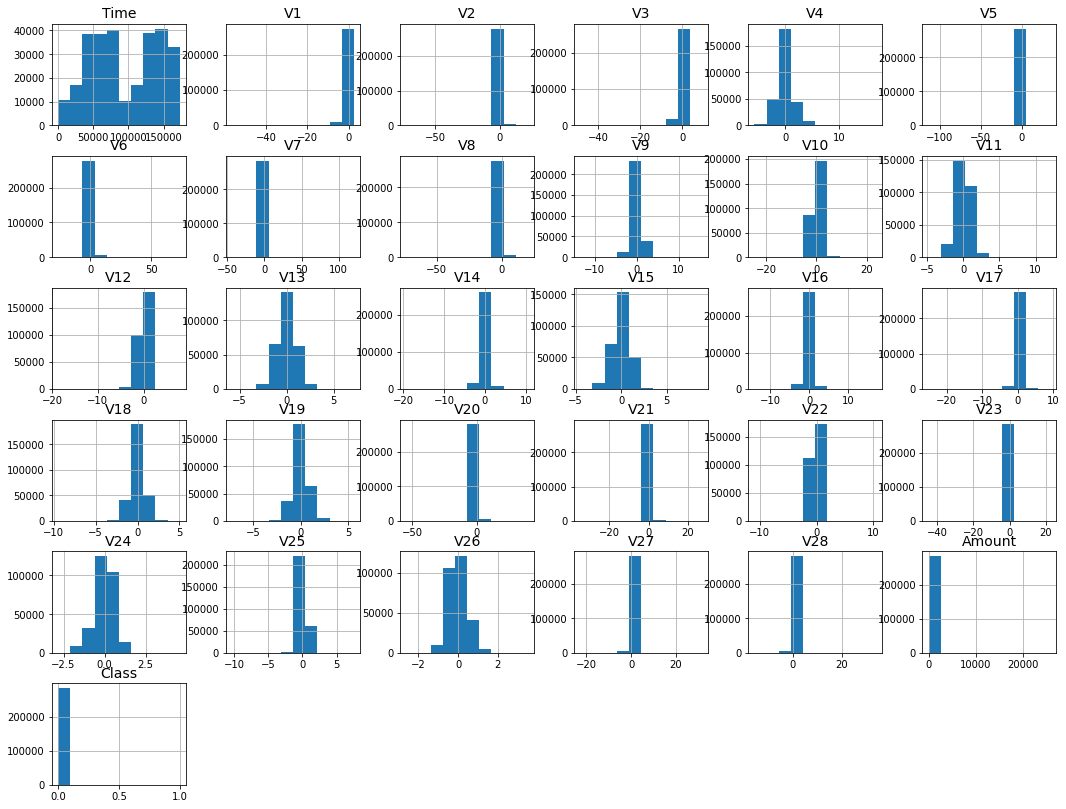

In [8]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

df.hist(figsize=(18, 14))
plt.show()

We can't extract much information from most of the features, barring amount and time features, which look like they follow a bimodal distribution and a power law distribution, respectively:

- [About bimodal distributions](https://www.statisticshowto.com/what-is-a-bimodal-distribution/)
- [About power law distributions](https://wiki.analytica.com/index.php?title=Power_law_distribution#:~:text=The%20Power%20law%20distribution%20is,propto%20x%5E%7B%2D%5Clambda%7D%20%24)

# <a id='3'><font color="steelblue"><b>Designing pipelines and generating a baseline</b></font></a>

<a href="#0" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Table of Contents</a>

### <a id='31'><font color="steelblue"><b>Splitting data in training, validation and test sets</b></font></a>


In [9]:
strat_train, X_test = train_test_split(
    df, test_size = 0.2, stratify=df['Class'], random_state=SEED
)

print(strat_train.shape, X_test.shape)

(227845, 31) (56962, 31)


In [10]:
X_train, X_valid = train_test_split(
    strat_train, test_size = 0.2, stratify=strat_train['Class'], random_state=SEED
)
print(X_train.shape, X_valid.shape)

(182276, 31) (45569, 31)




#### <a id='32'><font color="steelblue"><b>Check target feature imbalance via pie-plot </b></font></a>


Check target feature imbalance via pie-plot: 

In [11]:
def plot_pie_chart(df, feature):
    labels = [str(df[feature].unique()[i]) for i in range(df[feature].nunique())]
    values = [df[feature].value_counts()[i] for i in range(df[feature].nunique())]
    
    trace = go.Pie(labels=labels, values=values)
    
    py.iplot([trace])
    
def plot_pie_chart_split(df_train, df_test, feature):
    
    labels_train = [str(df_train[feature].unique()[i]) for i in range(df_train[feature].nunique())]
    values_train = [df_train[feature].value_counts()[i] for i in range(df_train[feature].nunique())]
    
    labels_test = [str(df_test[feature].unique()[i]) for i in range(df_test[feature].nunique())]
    values_test = [df_test[feature].value_counts()[i] for i in range(df_test[feature].nunique())]

    fig = make_subplots(rows=1, cols=2, subplot_titles=("training set", "test set"),
                       specs=[[{"type": "pie"}, {"type": "pie"}]])

    fig.add_trace(go.Pie(labels=labels_train, values=values_train), row=1, col=1)
    fig.add_trace(go.Pie(labels=labels_test, values=values_test), row=1, col=2)

    fig.update_layout(height=600, width=800, title_text="side by side comparison of correct class stratification and split",
                     showlegend=True)
    fig.show()

In [12]:
plot_pie_chart(df, "Class")

In [13]:
plot_pie_chart_split(X_train, X_valid, "Class")

We can see how train_test_split stratified our data correctly, assuring representation of the minority class in our training, validation and test sets in the same proportion as with the original dataset.

### <a id='33'><font color="steelblue"><b>Perform baseline evaluation using several models</b></font></a>

<a href="#0" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Table of Contents</a>

In [14]:
y_train = X_train['Class']
X_train = X_train.drop('Class', axis=1)

In [15]:
y_valid = X_valid['Class']
X_valid = X_valid.drop("Class", axis=1)

In [16]:
y_test = X_test['Class']
X_test = X_test.drop('Class', axis=1)

A function to quickly generate tuples of classifiers:

In [17]:
def get_models():
    models = []
    models.append(('RF', RandomForestClassifier()))
    models.append(('XGBc', xgb.XGBClassifier()))
    models.append(('LGBC', LGBMClassifier()))
    
    return models

get_models()

[('RF', RandomForestClassifier()),
 ('XGBc',
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, gamma=None,
                gpu_id=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=None, max_bin=None,
                max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
                max_leaves=None, min_child_weight=None, missing=nan,
                monotone_constraints=None, n_estimators=100, n_jobs=None,
                num_parallel_tree=None, predictor=None, random_state=None,
                reg_alpha=None, reg_lambda=None, ...)),
 ('LGBC', LGBMClassifier())]

#### <a id='34'><font color="steelblue"><b>Testing undersamplers and oversamplers</b></font></a>

<a href="#0" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Table of Contents</a>

We will use <code style="color:salmon">&lt;Counter&gt;</code> from the collections module to check the number of fraud and non-fraud samples in our traning set before resampling:

In [18]:
print(f'Before resample: {Counter(y_train)}')

Before resample: Counter({0: 181961, 1: 315})


To calculate the optimal sampling strategy for our resamplers, we will use the following formula:

Desired proportion of minority samples vs majority samples = 
(Samples of Minority Class) / (Samples of Majority Class)

As I am going to undersample the majority class first, and then follow-up with oversampling the minority class (artificially generating samples similar to our fraud classes), we want to approximately define how many samples of our majority class we want to have after undersampling, and how many samples from the minority classes we desire to have after oversampling:

In [19]:
315/60_000

0.00525

In [20]:
900/60_000

0.015

The end result after resampling the data will be
- (I) After undersampling:
    - **Majority Class : Non-fraud Cases** : 60,000 samples
    - **Minority Class : Fraud Cases** : 315 samples
- (II) After undersampling:
    - **Majority Class : Non-fraud Cases** : 60,000 samples
    - **Minority Class : Fraud Cases** : 900 samples

We will use RandomUnderSampler and SMOTE algorithms from the imblearn library to undersample and oversample our training dataset, respectively.

In [21]:
under = RandomUnderSampler(sampling_strategy = 0.00525, random_state=SEED)
over = SMOTE(sampling_strategy = 0.015, random_state=SEED)

steps = [('under', under),('over', over)]
sampler_pipe = imblearn.pipeline.Pipeline(steps=steps)
X_rs, y_rs = sampler_pipe.fit_resample(X_train, y_train)

print(f' RandomUnderSampler followed by SMOTE Oversampler: {Counter(y_rs)}')

imbalanced_steps = [('under', under),('over', over)]
imbalanced_steps

 RandomUnderSampler followed by SMOTE Oversampler: Counter({0: 59999, 1: 899})


[('under', RandomUnderSampler(random_state=42, sampling_strategy=0.00525)),
 ('over', SMOTE(random_state=42, sampling_strategy=0.015))]

### <a id='35'><font color="steelblue"><b>Cross validation - imbalanced pipeline function</b></font></a>

<a href="#0" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Table of Contents</a>

The most commonly used techniques to deal with imbalanced data are data resampling either the majority of the class, oversampling the minority class, or doing both in combination. Undersampling can easily be visualized with the following illustration:

<figure>
<div style="text-align:center"><img src="https://github.com/henarejosSinh/kaggle_projects/blob/main/pictures/credit%20card%20fraud/imbalanced_under.png?raw=true" alt="Trulli">
<figcaption align = "center"><b>Illustration of undersampling</b></figcaption>
    </div>
</figure>

One problem that can arise from using resamplers during cross validation, specially oversamplers, is data leaking happening before fold generation during cross validation (figure below, left). As a result, training chunks of the fold can contain novel synthetic data, that "leaks" information from the original data, leading to overfitting and incorrect measure of performance againts the validation chunk. 


Incorrectly doing resampling during CV             |  Correctly doing resampling during CV
:-------------------------:|:-------------------------:
 ![Wrong way](https://github.com/henarejosSinh/kaggle_projects/blob/main/pictures/credit%20card%20fraud/imbalanced_over_wrong.jpg?raw=true) | ![Right way](https://github.com/henarejosSinh/kaggle_projects/blob/main/pictures/credit%20card%20fraud/imbalanced_over_cv.jpg?raw=true) 
 
<!--  ![alt-text-1](image1.png "title-1") ![alt-text-2](https://github.com/henarejosSinh/kaggle_projects/blob/main/pictures/credit%20card%20fraud/imbalanced_over_cv.jpg?raw=true "title-2") -->


We will avoid this common pitfall when working with imbalanced datasets using the imblearn own pipeline function, and the pipeline will fit, balance the data and perform cross validation like in the right figure. I encourage to consult the referenced blog below, as it is perfectly explained and exemplified why using a pipeline avoids this common mistake and obtains the same results as you would if you were to write it manually.

Note that for CV, we will need to adjust the sampling strategies for the resamplers. For that, we need to calculate how many samples we will have in each fold. For 5-fold CV, our training set will be divided in five chunks: 

182,276 samples / 5 = ~36,455 samples per chunk

Since **one chunk will be used for validation,** in reality we have ~145,821 samples that will be used for training. 
Correct representation of fraud classes in both the traning and validation chunks can be achieved with StratifiedKfold function from sci-kit learn.
Since the proportion of minority classes is 0.00173 for the whole dataset, then 
145,821 samples will have ~252 fraud cases (0.00173 * 145821), while the validation chunk for that fold will have 63 frauds (0.00173 * 36455). 

Knowing this beforehand, the resampling for the training chunks in each fold of the 5-fold CV will look like this:

- (I) Undersampling:
    - **Sampling strategy** =  We want 60,000 non fraud samples. 252/60,000 = 0.0042
    - **Majority Class : Non-fraud Cases** : 60,000 samples
    - **Minority Class : Fraud Cases** : 252 samples
- (II) Oversampling:
     - **Sampling strategy** =  We want 900 fraud samples. 900/60,000 = 0.015
    - **Majority Class : Non-fraud Cases** : 60,000 samples
    - **Minority Class : Fraud Cases** : 900 samples


<h3> Key points </h3>

* Undersampling and oversampling are the most common techniques when dealing with imbalanced data. Manual approaches, as long as done carefully specially when performing cross validation, are valid, but designing pipelines makes the process much easier and clean.
* Sampling strategies need to be thoughfully planned so we end up with the desired number of instances for the majority and minority classes. Extra attention must be given to the way sampling strategies are modified when dividing sets into chunks to form the folds during cross validation.
* Resampling must only happen during cross validation, after the chunks have been generated. Resampling will happen for the training chunks only, leaving the validation set untouched, preventing overfitting specially for oversampling.

<h3> References </h3>

- [imblearn pipeline documentation](https://imbalanced-learn.org/stable/references/pipeline.html?highlight=pipeline#module-imblearn.pipeline)
-[How to do cross-validation when upsampling data](https://kiwidamien.github.io/how-to-do-cross-validation-when-upsampling-data.html)
- [Kernel from Janio Martinez Bachmann](https://www.kaggle.com/code/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets)

In [22]:
under = RandomUnderSampler(sampling_strategy = 0.0042, random_state=SEED)
over = SMOTE(sampling_strategy = 0.015, random_state=SEED)

imbalanced_steps = [('under', under),('over', over)]
imbalanced_steps

[('under', RandomUnderSampler(random_state=42, sampling_strategy=0.0042)),
 ('over', SMOTE(random_state=42, sampling_strategy=0.015))]

#### <a id='36'><font color="steelblue"><b>Launching baseline pipelines</b></font></a>

<a href="#0" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Table of Contents</a>

Taking into account everything, the following function will generate a pipeline for each tuple of classfiers passed (XGB and LGB). The pipeline will include the following steps:

* Undersampling followed by oversampled as defined previously.
* Scaling using MaxAbsScaler to delimit features to the 0-1 range, with 1 being the maximum value of said feature.
* Transformation by Quantile transformer, adjusting the features to follow a normal distribution, and reducing the impact of outliers.

Results will be hold in three variables:

* A list of tuples, with the pipelines generated, and a name for downstream reference.
* A list of cross_validate functions results, with each element corresponding to a different pipeline.
* A dataframe with the mean and standard deviation for scored metrics.

In [23]:
def cross_validate_imbalanced_datasets(X_train, y_train, models, num_folds, imbalanced_steps: list):
    
    scoring = ['roc_auc', 'precision', 'recall', 'f1']
    pipes = []
    cv_results_list = []
    df_res = []
    kfold = RepeatedStratifiedKFold(n_splits=num_folds, random_state=SEED, n_repeats=1)
    
    for name, model in models:
        
        scaler_steps = [('max_scaler', MaxAbsScaler()),
            ('quantile_transf', QuantileTransformer(output_distribution="normal")),
            (name, model),
        ]
        
        imbalanced_scaler_pipe = imblearn.pipeline.Pipeline(steps=imbalanced_steps + scaler_steps)
        
        # perform cross-validation
        cv_results = cross_validate(imbalanced_scaler_pipe, X_train, y_train, cv=kfold, scoring=scoring)
        
        results = round(pd.DataFrame(cv_results), 4) # round to 4 decimals each metric
        res_fit_time = round(results["fit_time"].sum(), 4)
        res_score_time = round(results["score_time"].sum(), 4)
        results_mean = list(results.loc[:, "test_roc_auc":].mean().values) 
        results_std = list(results.loc[:, "test_roc_auc":].std().values) 
        results_toframe = [res_fit_time, res_score_time] + [(str(round(results_mean[i], 4)) +'+/-'+
            str(round(results_std[i], 4))) for i in range(len(results.loc[:, "test_roc_auc":].columns))]

        results_df = pd.DataFrame([results_toframe],
                                               columns=['Fit time (s)','Score time (s)'] + scoring, 
                                               index=[f'{name}_pipe']
                                              )
        df_res.append(results_df)
        cv_results_list.append(cv_results)
        pipes.append((f'{name}_pipe', imbalanced_scaler_pipe))

        print(f"{results_df} \n")
        
    return pipes, cv_results_list, pd.concat(df_res, axis=0)
    

In [24]:
pipes, cv_results, models_results = cross_validate_imbalanced_datasets(X_train, y_train, get_models(), 5, imbalanced_steps)

         Fit time (s)  Score time (s)          roc_auc        precision  \
RF_pipe      241.3136          7.7057  0.9671+/-0.0103  0.8578+/-0.0593   

                  recall              f1  
RF_pipe  0.8286+/-0.0426  0.8423+/-0.044   

           Fit time (s)  Score time (s)          roc_auc        precision  \
XGBc_pipe       77.4161          3.7332  0.9841+/-0.0115  0.8577+/-0.0425   

                    recall               f1  
XGBc_pipe  0.8317+/-0.0329  0.8439+/-0.0295   

           Fit time (s)  Score time (s)          roc_auc       precision  \
LGBC_pipe       10.9699          4.0457  0.9817+/-0.0084  0.869+/-0.0565   

                    recall               f1  
LGBC_pipe  0.8254+/-0.0389  0.8458+/-0.0381   



In [25]:
models_results

,Fit time (s),Score time (s),roc_auc,precision,recall,f1
RF_pipe,241.3136,7.7057,0.9671+/-0.0103,0.8578+/-0.0593,0.8286+/-0.0426,0.8423+/-0.044
XGBc_pipe,77.4161,3.7332,0.9841+/-0.0115,0.8577+/-0.0425,0.8317+/-0.0329,0.8439+/-0.0295
LGBC_pipe,10.9699,4.0457,0.9817+/-0.0084,0.869+/-0.0565,0.8254+/-0.0389,0.8458+/-0.0381


In [26]:
pipes_names = [tup[0] for tup in pipes]
pipes_names

['RF_pipe', 'XGBc_pipe', 'LGBC_pipe']

Box plot to visualize cross_validate functions results, considering the results for each fold.

In [27]:
class plot_box_models(object):
    
    
    def __Trace(self, name, value): 
    
        trace = go.Box(
            y=value,
            name = name,
            marker = dict(
                color = 'rgb(0, 128, 128)',
            )
        )
        return trace

    def plot_result(self, names, results, metric_key):
        '''
        results is a cv dict that can contain several metrics
        input the name of the metric of interest as variable metric_key
        '''
        data = []

        for i in range(len(names)):
            data.append(self.__Trace(names[i], results[i][metric_key]))


        py.iplot(data)

In [28]:
plot_box_models().plot_result(pipes_names, cv_results, 'test_f1')

#### <a id='37'><font color="steelblue"><b>Precision-recall curve function and baseline results</b></font></a>

<a href="#0" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Table of Contents</a>

The following cells generate a PR curve for the results of the pipelines launched in previous steps. 

In [29]:
from cycler import cycler

mpl.rcParams["axes.prop_cycle"] = cycler( color = ["navy", "turquoise", "darkorange", "cornflowerblue", "seagreen", 
       "teal", "indianred", "yellowgreen", "darkmagenta", "sienna"])

print(plt.style.available)
# plt.style.use('seaborn') # you can try different styles, though in the same kernel you need to revert to default before changing to another one
# or the styles will be combined.
plt.style.use('default')

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [30]:
def plot_pr_curve_from_cross_validate_results(cv_results: list, model_names: list):
      
    mpl.rcParams['axes.linewidth'] = 3 
    mpl.rcParams['lines.linewidth'] =7
    plt.figure(figsize=(8, 12))
    plt.subplots_adjust(hspace=0.3, )
    plt.suptitle("PR curves", fontsize=18, y=0.95)
    plot_n = 0
    
    for name, results in zip(model_names, cv_results):
        
        plot_n += 1
        c = 1
        
        ax = plt.subplot(len(model_names), 1, plot_n)
        pr_aucs = []
        df_temp = pd.DataFrame(results)
        recall = df_temp["test_recall"]
        precision = df_temp["test_precision"]

        for (i, j) in zip(recall, precision):
            recall_plot = [1., i, 0.]
            precision_plot = [0., j, 1.]

            pr_auc = auc(recall_plot, precision_plot)
            pr_aucs.append(pr_auc)
            plt.plot(recall_plot, precision_plot, lw=3, alpha=0.5, label=f'Fold {c} AUCPR = {pr_auc:.2}',)
            c += 1

        plt.plot([0, 1], [1, 0], linestyle='--', lw=3, color='k', label='Luck', alpha=.8)
        mean_pr_auc = np.mean(pr_aucs)
        std_pr_auc = np.std(pr_aucs)

        plt.plot([0., precision.mean(), 1.], [1., recall.mean(), 0.], color='crimson',
                     label=f'Mean (AUCPR = {mean_pr_auc:.3} $\pm$ {std_pr_auc:.2}',
                     lw=4)

        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('Recall' ,  fontweight = "bold" , fontsize=15)
        plt.ylabel('Precision',fontweight = "bold" , fontsize=15)
        plt.tick_params(axis='both', which='major', labelsize=10)
        plt.legend( prop={'size': 10 } , loc = "lower left")

        f_scores = np.linspace(0.2, 0.8, num=4)
        lines, labels = [], []
        for f_score in f_scores:
            x = np.linspace(0.01, 1)
            y = f_score * x / (2 * x - f_score)
            (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.1)
            plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

        handles, labels = ax.get_legend_handles_labels()
        handles.extend([l])
        labels.extend(["iso-f1 curves"])

        ax.legend(handles=handles, labels=labels, loc="lower left")
        ax.set_title(f"Precision-Recall curve 10 fold cv for {name} model")

    plt.show()

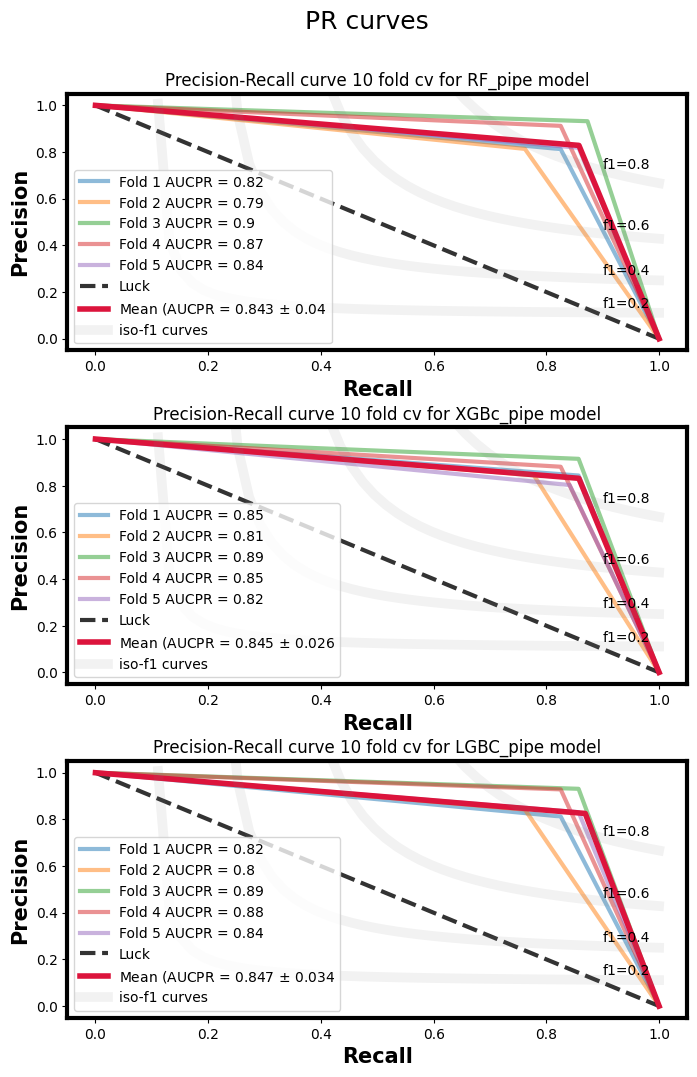

In [31]:
plot_pr_curve_from_cross_validate_results(cv_results, pipes_names)

We can see that cross validation results are good enough with both XGB and LGB classifiers, with no feature selection, engineering or other steps implemented.

#### <a id='38'><font color="steelblue"><b>Selecting best pipeline and reporting baseline results</b></font></a>

<a href="#0" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Table of Contents</a>

In this function, pipelines results are evaluated and the best model is returned according to the selected metric:

In [32]:
def select_model_by_metric(cv_results: list, models: list, metric: str):
    
    model_names = [i[0] for i in models]
    model_metrics = {}
    
    for name, results in zip(model_names, cv_results):
        model_metrics[name] = 0.
        df_temp = pd.DataFrame(results)
        model_metrics[name] = df_temp[metric].mean()
        
    best_model = max(model_metrics, key=model_metrics.get)
    
    print(f'best model for {metric} score was {best_model}')
    
    return ([i[1] for i in models if i[0] == best_model][0], best_model)

selected_model = select_model_by_metric(cv_results, pipes, "test_f1")
selected_model[0]

best model for test_f1 score was LGBC_pipe


Pipeline(steps=[('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.0042)),
                ('over', SMOTE(random_state=42, sampling_strategy=0.015)),
                ('max_scaler', MaxAbsScaler()),
                ('quantile_transf',
                 QuantileTransformer(output_distribution='normal')),
                ('LGBC', LGBMClassifier())])

With these functions we plot the classification report, confusion matrix and precision-recall curve obtained after fitting the selected model with the training set and evaluating performance against validation and test sets.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       0.86      0.80      0.83        79

    accuracy                           1.00     45569
   macro avg       0.93      0.90      0.91     45569
weighted avg       1.00      1.00      1.00     45569



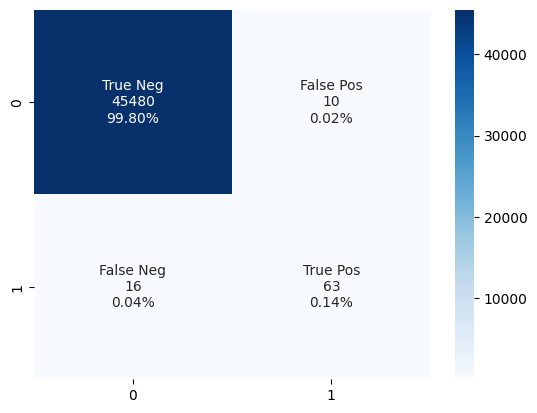

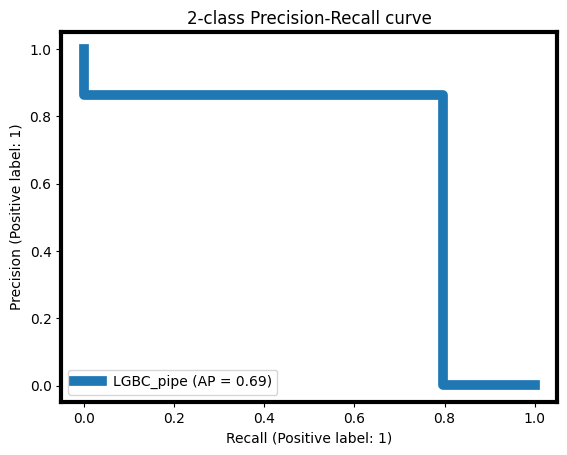

In [33]:
def plot_report_model_performance(model, model_name, X_training, y_training, X_testing, y_testing):
    
    model.fit(X_training, y_training)
    preds = model.predict(X_testing)
    
    print(classification_report(y_testing, preds))
        
    cm = confusion_matrix(y_testing, preds)
    names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    counts = [value for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names, counts, percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm,annot = labels,cmap = 'Blues',fmt ='')
    
    display = PrecisionRecallDisplay.from_predictions(y_testing, preds, name=f"{model_name}")
    _ = display.ax_.set_title("2-class Precision-Recall curve")
    plt.show(display)
    
plot_report_model_performance(selected_model[0], selected_model[1], X_train, y_train, X_valid, y_valid)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.82      0.82      0.82        98

    accuracy                           1.00     56962
   macro avg       0.91      0.91      0.91     56962
weighted avg       1.00      1.00      1.00     56962



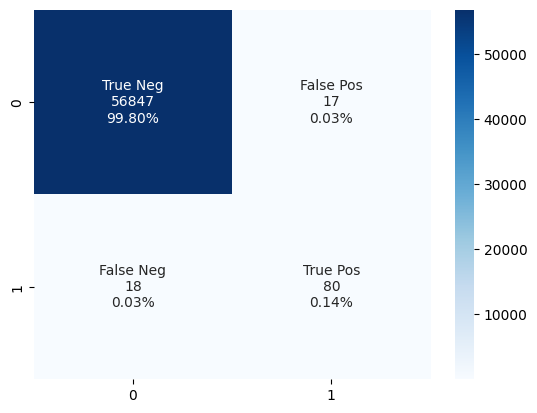

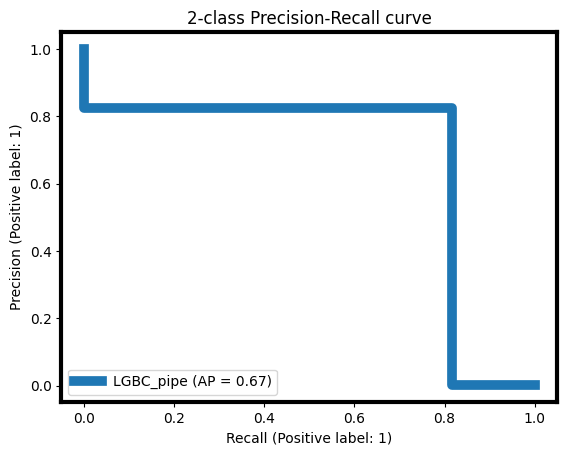

In [34]:
plot_report_model_performance(selected_model[0], selected_model[1], X_train, y_train, X_test, y_test)

We see how we can achieve decent f1 and precision-recall AUC even without tweaking the hyperparameters of LGB classifier.

<h3> Key points </h3>

* Baseline results were decent, with over 0.8 of f1 score, ~0.67 of AP (precision-recall AUC) for the LGB pipeline.
* Only MaxAbsScaler and QuantileTransformers were applied, with no further tweaking.


# <a id='4'><font color="steelblue"><b>Feature selection</b></font></a>

<a href="#0" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Table of Contents</a>

Once we have a baseline done, in this section we will try to perform feature selection by selecting the most correlated features with our Class feature, and perform feature selection via ANOVA.

<h3> Key points </h3>

* Pearson's correlation reveals several "Vx" features positively and negatively correlated with the Class feature. While the correlation is not that strong, it serves as a stepping stone for feature selection.
* With ANOVA, we try to find those features that discriminate better between the distribution of fraud and non-fraud cases. Features that were low variance and more compactness between samples for both distributions will discriminate better and perform better when trying to discriminate between classes.

<h3> References </h3>

- [Anova for feature selection](https://towardsdatascience.com/anova-for-feature-selection-in-machine-learning-d9305e228476)
- [Amazing post explaining the idea behind using ANOVA for feature selection](https://datascience.stackexchange.com/questions/74465/how-to-understand-anova-f-for-feature-selection-in-python-sklearn-selectkbest-w)


In [35]:
training_df = pd.concat([X_train, y_train], axis=1)  # we need the target feature in the same dataframe to perform correlations
training_df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
1458,1131.0,-0.441959,1.080868,1.410925,0.096693,0.135221,-0.706547,0.666114,0.013606,-0.507651,...,-0.202324,-0.469792,0.065107,0.364271,-0.253785,0.079310,0.263524,0.100546,7.15,0
119883,75619.0,1.226589,0.169271,0.326460,0.493162,-0.123181,-0.313537,-0.009737,-0.048594,0.058451,...,-0.247942,-0.696903,0.113911,-0.289866,0.190943,0.145525,-0.014312,0.013489,9.99,0
177219,123088.0,1.708188,-0.698579,-0.964903,0.474704,-0.260791,0.238362,-0.589549,0.055753,1.165361,...,0.031552,-0.082551,0.077579,-0.017251,-0.472592,0.362583,-0.016077,0.022792,171.52,0
191980,129483.0,2.096642,0.093645,-2.159035,0.955814,1.070886,-0.064135,0.432008,-0.123855,0.193407,...,-0.005335,0.152805,-0.165407,-1.468552,0.579626,-0.417287,-0.025580,-0.089699,1.00,0
252575,155871.0,-0.569459,-0.956243,2.007415,-1.590362,-0.186744,-0.842440,-0.697689,-0.005533,1.951300,...,0.366197,1.234458,-0.000220,0.030027,-0.725066,-0.083545,0.068478,-0.007934,21.20,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24156,33092.0,0.016195,0.837004,1.412539,1.702548,-0.617590,0.261030,-0.535771,-1.523846,0.150172,...,1.545518,-0.160930,-0.005084,0.633019,0.803724,-0.087087,0.269657,0.239345,1.20,0
258612,158734.0,-3.385850,3.249002,-2.246492,0.993333,-0.729694,0.947889,-2.819625,-3.795863,-1.957584,...,-2.225798,1.282028,-0.045040,0.039099,0.605973,1.199836,-0.763545,-0.077492,37.69,0
19453,30296.0,-1.737090,-0.890132,3.420714,0.395711,-0.067610,-0.335518,-0.215682,0.302557,1.503359,...,-0.022212,-0.034168,-0.031295,0.659424,0.629384,-0.565606,-0.144327,-0.131447,79.50,0
129088,78945.0,-0.637908,1.143421,2.017952,-0.058035,0.144581,-0.646670,0.973703,-0.297624,-0.487969,...,-0.171860,-0.209624,-0.008196,0.627083,-0.378823,0.019724,0.036641,-0.044300,3.96,0


In [36]:
corr_matrix = training_df.corr()
print(corr_matrix["Class"].sort_values(ascending=False)[:10], "\n")
print(corr_matrix["Class"].sort_values(ascending=True)[:10])

Class    1.000000
V11      0.155605
V4       0.137889
V2       0.096083
V21      0.036056
V19      0.033496
V20      0.019007
V27      0.013496
V8       0.012514
V28      0.008042
Name: Class, dtype: float64 

V17   -0.333415
V14   -0.303340
V12   -0.264578
V10   -0.222691
V3    -0.201858
V16   -0.199553
V7    -0.198060
V18   -0.114329
V1    -0.106324
V5    -0.102398
Name: Class, dtype: float64


In [37]:
high_corr_base = corr_matrix["Class"].sort_values(ascending=False)[:5].index.to_list()
high_corr_base = high_corr_base + corr_matrix["Class"].sort_values(ascending=True)[:5].index.to_list()
print(high_corr_base)

['Class', 'V11', 'V4', 'V2', 'V21', 'V17', 'V14', 'V12', 'V10', 'V3']


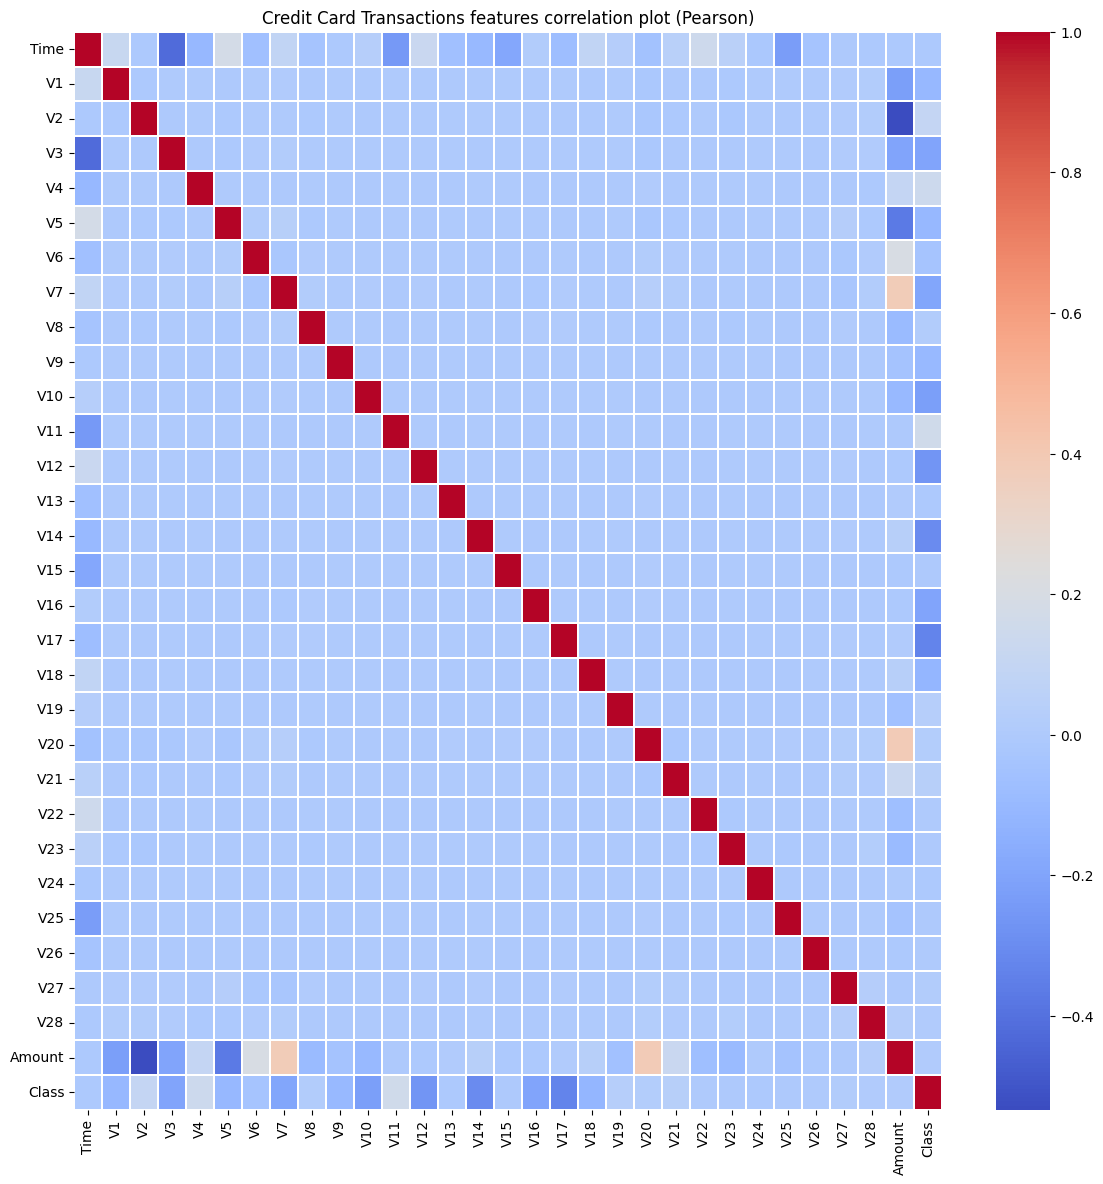

In [38]:
plt.figure(figsize = (14,14))
plt.title('Credit Card Transactions features correlation plot (Pearson)')
corr = training_df.corr()
sns.heatmap(corr,xticklabels=corr.columns, yticklabels=corr.columns, linewidths=.1,cmap="coolwarm")
plt.show()

We can see how several of the "Vx" feaures are correlated with our target feature. We can confirm this hypothesis with linear model plots: 

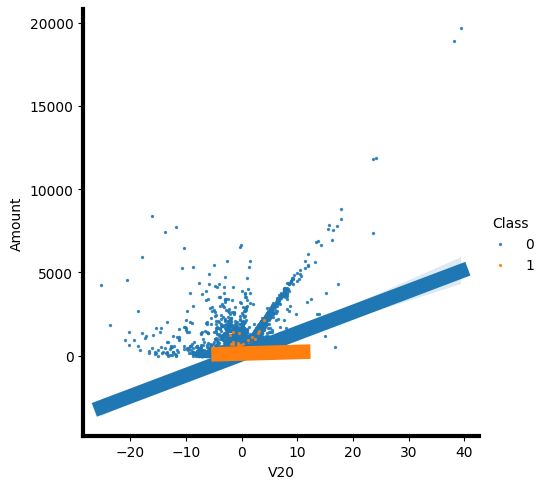

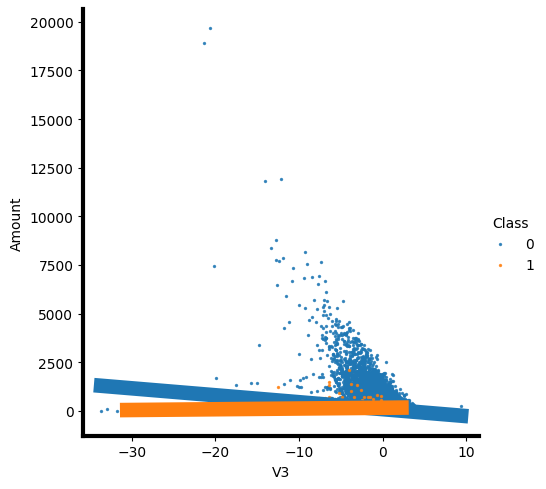

In [39]:
s = sns.lmplot(x='V20', y='Amount',data=training_df, hue='Class', fit_reg=True,scatter_kws={'s':2}) # positive feature correlation example
s = sns.lmplot(x='V3', y='Amount',data=training_df, hue='Class', fit_reg=True,scatter_kws={'s':2}) # negative feature correlation example
plt.show()

Text(0.5, 1.0, 'top 10 features selected by ANOVA ')

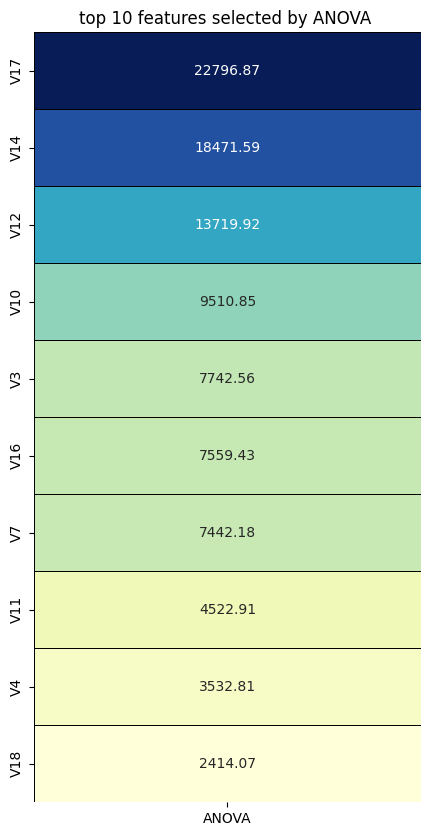

In [40]:
features = training_df.loc[:, :"Amount"]
target = training_df.loc[:, "Class"]

best_features = SelectKBest(score_func = f_classif, k='all')
fit = best_features.fit(features, target)

feature_scores = pd.DataFrame(data=fit.scores_, index=list(features.columns), columns=['ANOVA'])
feature_scores = feature_scores.sort_values(ascending=False, by='ANOVA')

fig,ax = plt.subplots(nrows = 1, ncols = 1, figsize = (5,10))

plt.subplot(1,1,1)
sns.heatmap(feature_scores.iloc[:10,:], annot = True, linewidths = 0.4, linecolor = 'black',
            cbar = False, fmt = '.2f', cmap="YlGnBu")
plt.title('top 10 features selected by ANOVA ')

In [41]:
high_corr_base_anova = list(set(feature_scores.iloc[:10, :].index.tolist()).union(set(high_corr_base)))
high_corr_base_anova.remove('Class')
high_corr_base_anova

['V21',
 'V7',
 'V3',
 'V18',
 'V12',
 'V10',
 'V16',
 'V2',
 'V11',
 'V4',
 'V17',
 'V14']

In [42]:
len(high_corr_base_anova)

12

Now, we plot the selected features class distributions to see if there is really a visible difference between classes.

<Figure size 640x480 with 0 Axes>

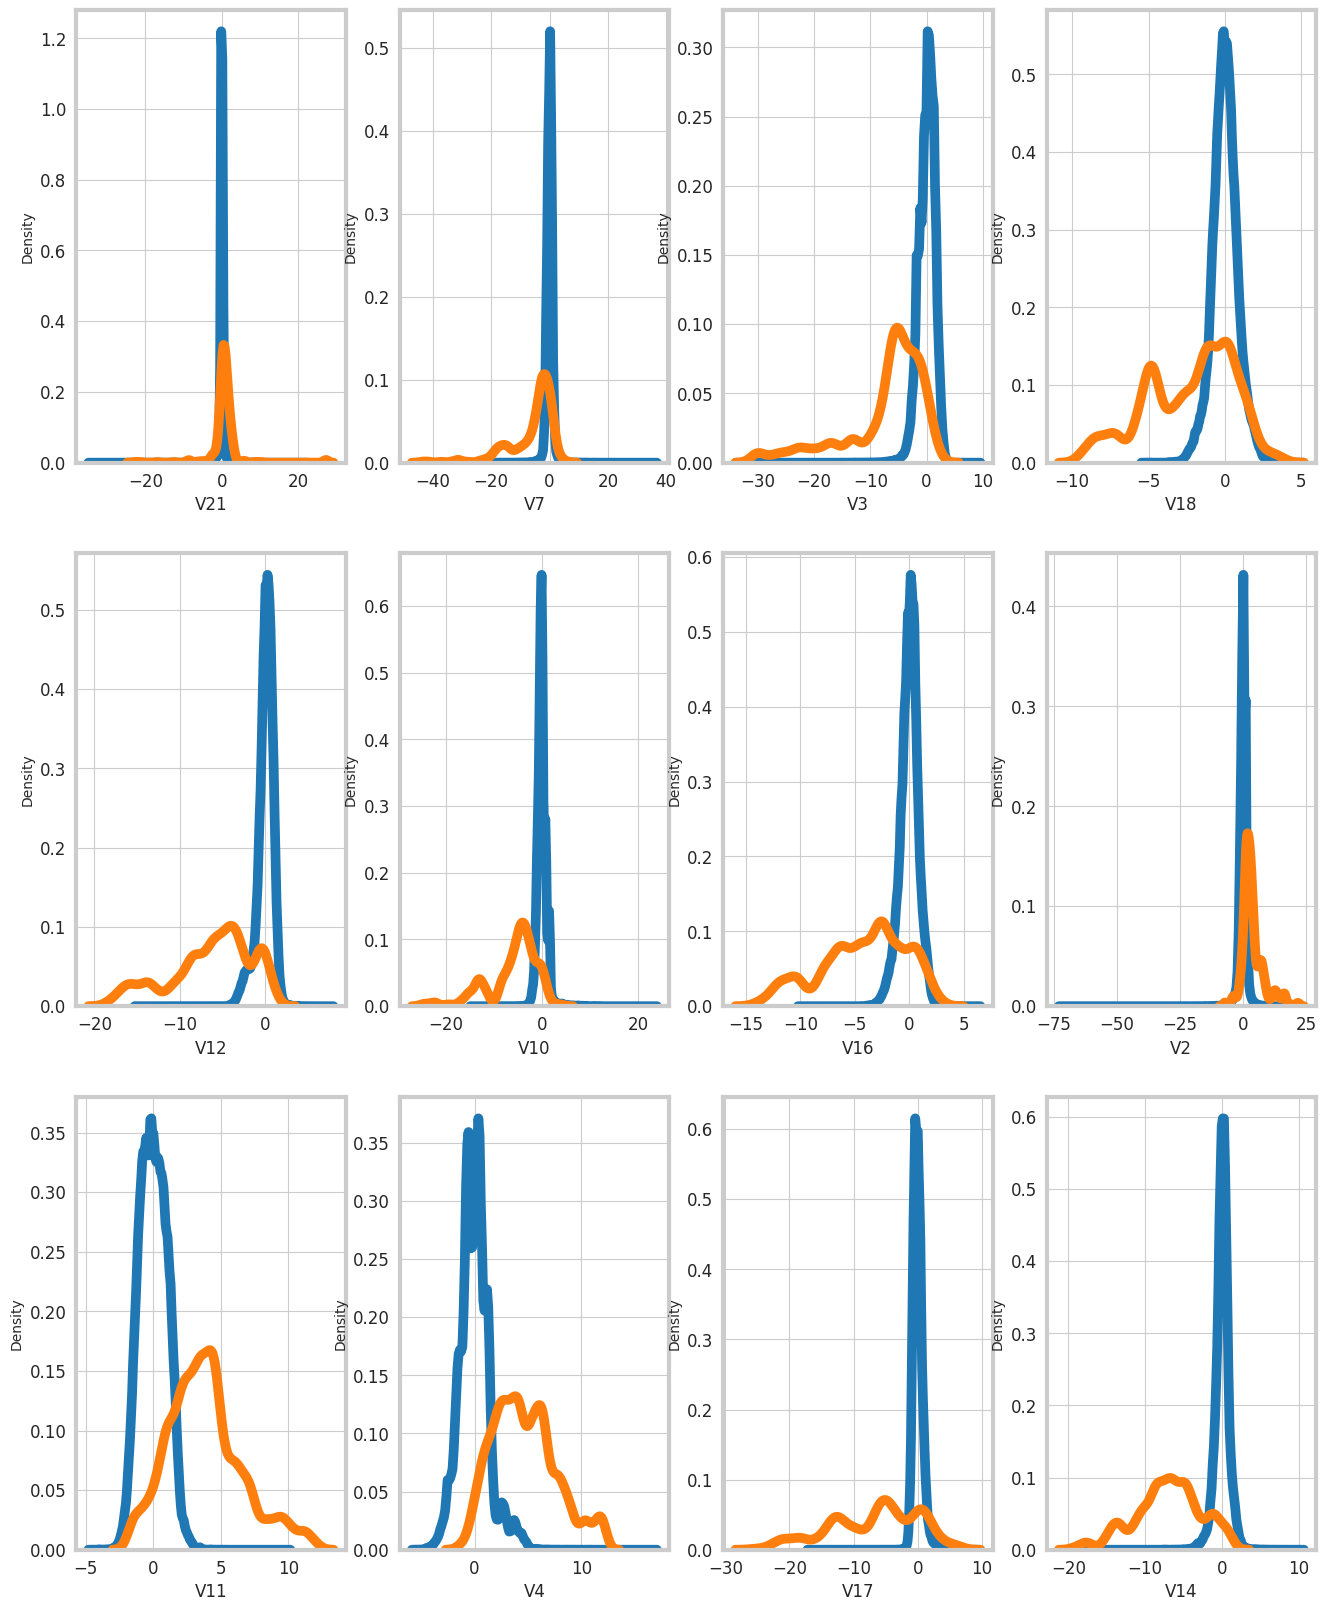

In [43]:
var = high_corr_base_anova

i = 0
temp0 = training_df.loc[training_df['Class'] == 0]
temp1 = training_df.loc[training_df['Class'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(3, 4, figsize=(16,20))

for feature in var:
    i += 1
    plt.subplot(3,4, i)
    sns.kdeplot(temp0[feature], bw_adjust=0.5, label="Class = 0")
    sns.kdeplot(temp1[feature], bw_adjust=0.5, label="Class = 1")
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

# <a id='5'><font color="steelblue"><b>Prediction with selected features</b></font></a>

<a href="#0" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Table of Contents</a>

Once we have selected our features, is time to test our pipelines and see if we improve our results compared to the baseline.

<h3> Key points </h3>

* Model performance was slightly improve with feature selection.
* Once again, LGB came on top as best classifier for f1 score.

I will be adding the time and amount features as I think they can be predictive once they are scaled and outliers are removed via quantile transformation

In [44]:
selection = high_corr_base_anova + ["Time", "Amount"]
print(selection)

['V21', 'V7', 'V3', 'V18', 'V12', 'V10', 'V16', 'V2', 'V11', 'V4', 'V17', 'V14', 'Time', 'Amount']


Lets launch our pipelines with the selected features:

In [45]:
pipes, cv_results, models_results = cross_validate_imbalanced_datasets(X_train[selection], y_train, 
                                                                       get_models(), 5, imbalanced_steps)

         Fit time (s)  Score time (s)          roc_auc        precision  \
RF_pipe       140.435          5.7086  0.9579+/-0.0161  0.8527+/-0.0581   

                  recall               f1  
RF_pipe  0.8317+/-0.0365  0.8415+/-0.0412   

           Fit time (s)  Score time (s)          roc_auc        precision  \
XGBc_pipe       45.9388          2.1361  0.9787+/-0.0119  0.8536+/-0.0558   

                    recall               f1  
XGBc_pipe  0.8349+/-0.0365  0.8433+/-0.0361   

           Fit time (s)  Score time (s)         roc_auc       precision  \
LGBC_pipe        5.7335          2.4582  0.9788+/-0.018  0.8473+/-0.053   

                    recall               f1  
LGBC_pipe  0.8349+/-0.0365  0.8406+/-0.0399   



In [46]:
models_results

,Fit time (s),Score time (s),roc_auc,precision,recall,f1
RF_pipe,140.4350,5.7086,0.9579+/-0.0161,0.8527+/-0.0581,0.8317+/-0.0365,0.8415+/-0.0412
XGBc_pipe,45.9388,2.1361,0.9787+/-0.0119,0.8536+/-0.0558,0.8349+/-0.0365,0.8433+/-0.0361
LGBC_pipe,5.7335,2.4582,0.9788+/-0.018,0.8473+/-0.053,0.8349+/-0.0365,0.8406+/-0.0399


In [47]:
pipes_names = [tup[0] for tup in pipes]
pipes_names

['RF_pipe', 'XGBc_pipe', 'LGBC_pipe']

In [48]:
plot_box_models().plot_result(pipes_names, cv_results, 'test_f1')

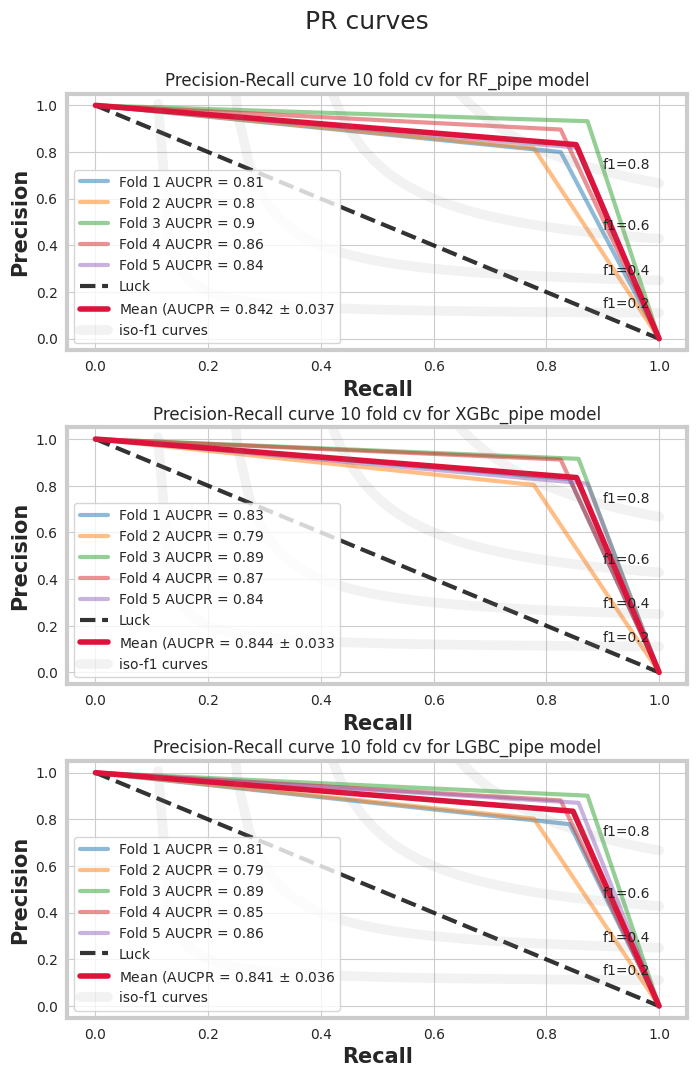

In [49]:
plot_pr_curve_from_cross_validate_results(cv_results, pipes_names)

In [50]:
selected_model = select_model_by_metric(cv_results, pipes, 'test_f1')
selected_model[0]

best model for test_f1 score was XGBc_pipe


Pipeline(steps=[('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.0042)),
                ('over', SMOTE(random_state=42, sampling_strategy=0.015)),
                ('max_scaler', MaxAbsScaler()),
                ('quantile_transf',
                 QuantileTransformer(output_distribution='normal')),
                ('XGBc',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=N...
                               gamma=None, gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=None,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, predictor=None,
                               random_state=None, reg_alpha=None,
                               reg_lambda=None, ...))])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       0.83      0.82      0.83        79

    accuracy                           1.00     45569
   macro avg       0.92      0.91      0.91     45569
weighted avg       1.00      1.00      1.00     45569



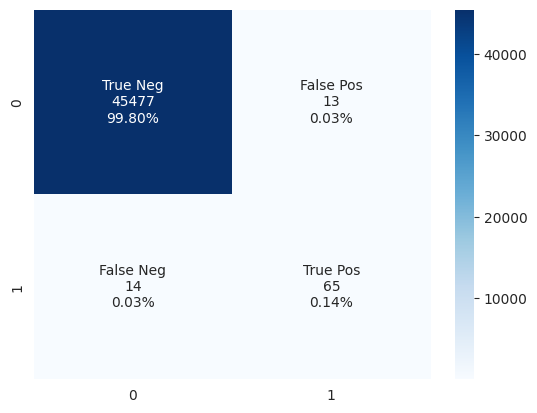

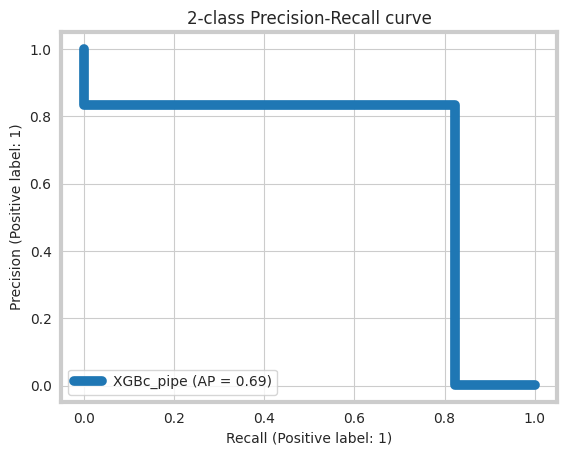

In [51]:
plot_report_model_performance(selected_model[0], selected_model[1], X_train[selection], y_train, X_valid[selection], y_valid)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.76      0.86      0.80        98

    accuracy                           1.00     56962
   macro avg       0.88      0.93      0.90     56962
weighted avg       1.00      1.00      1.00     56962



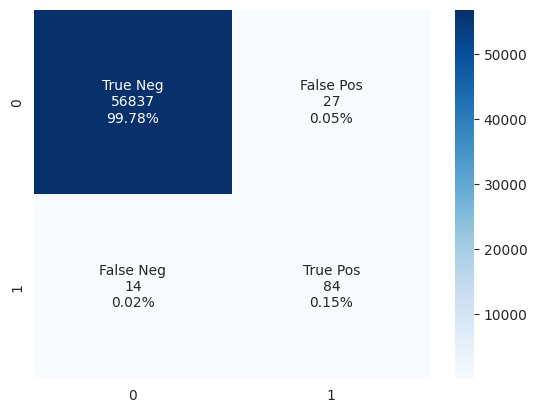

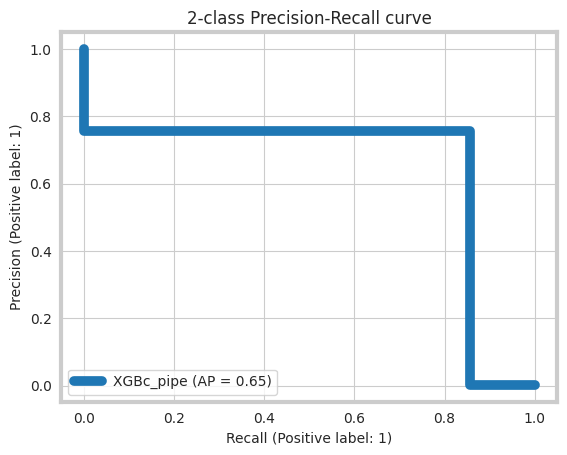

In [52]:
plot_report_model_performance(selected_model[0], selected_model[1], X_train[selection], y_train, X_test[selection], y_test)

# <a id="6"><font color="steelblue" size=+3><b>Conclusions</b></font></a>

<a href="#0" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Table of Contents</a>

Even if I tried to implement various steps crucial for machine learning projects, this is not a comprehensive notebook. Some steps that can be added to further improve performance vs baseline results:

* Performing feature engineering;
* Deeper data exploration and visualization (especially with time and amount features);
* Performing grid search to obtain the best parameters possible, as I defaulted in all the models;
* Further experiment with the undersamplers and oversamplers avalaible in the imblearn library;
* Perfoming stacking/consensus of various models instead of choosing a single one;
* And more: experimenting and studying other notebooks and kernels is the key to learn and suceed!

<a id="7"></a>
<font color="steelblue" size=+2><b>References & Further Reading</b></font>


* [Scikit-learn dataset transformations](https://scikit-learn.org/stable/data_transforms.html)
* [Machine learning mastery](https://machinelearningmastery.com/quantile-transforms-for-machine-learning/)
* [Machine learning friendly books post](https://www.kaggle.com/general/255972)